# Импорт пакетов

In [1]:
import pandas as pd
import torch 
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from dataframe import CustomDataset
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

from model import CustomResNet, CustomAlexNet, CustomGoogLeNet, CustomMobileNetV3
from utils import evaluate_model, plot_confusion_matrix

In [2]:
# фиксируем рандомный сид
seed  = 20
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

In [3]:
# детектируем девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Задание констант

In [4]:
classes_list = ['healthy', 'multiple_diseases', 'rust', 'scab']

train_csv_file = './data/train/train.csv'
train_images_dir = './data/train/images'
validation_csv_file = './data/validation/validation.csv'
validation_images_dir = './data/validation/images'

batch_size = 64

n_classes = len(classes_list)

# число эпох
num_epochs = 70
learning_rate = 0.0005

# Извлечение данных (формирование датасетов)

Добавляем аугментацию для лучшего обучения модели.

In [5]:
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # специальные значение нормализации для resnet
])

val_dataset = CustomDataset(validation_csv_file, 
                            validation_images_dir, 
                            classes_list, 
                            val_transform)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),  # Добавим вертикальное отражение
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # специальные значение нормализации для resnet
])

train_dataset = CustomDataset(train_csv_file, 
                              train_images_dir, 
                              classes_list, 
                              train_transform)

# Исследование данных

Class weights: [0.8654891304347826, 5.137096774193548, 0.7288329519450801, 0.7825552825552825]


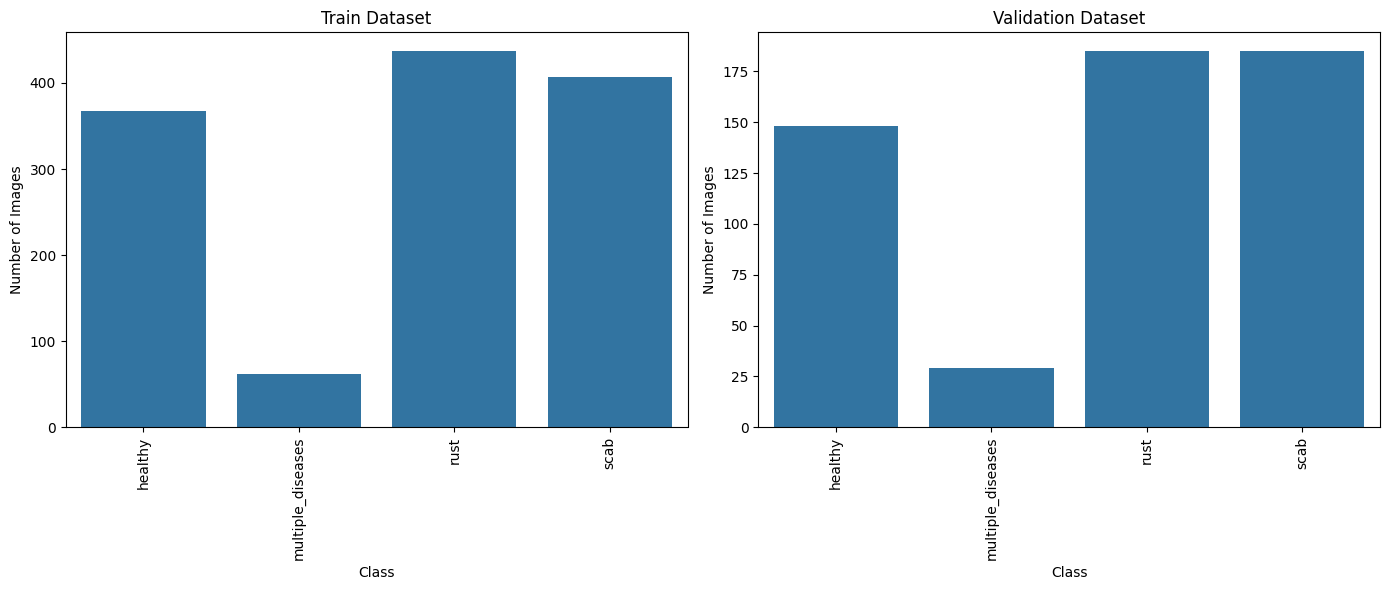

In [15]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1

# Подсчитать количество изображений в каждом классе для валидационного набора данных
val_class_counts = np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
    val_class_counts[label] += 1

# посчитаем веса для каждого класса
class_weights = (sum(train_class_counts.tolist()) / (len(classes_list) * train_class_counts)).tolist()
print(f"Class weights: {class_weights}")

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Формирование DataLoaders

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Определяем модель

In [9]:
model = CustomResNet(n_classes=n_classes)
# model = CustomAlexNet(n_classes=n_classes)
# model = CustomGoogLeNet(n_classes=n_classes)

# model = CustomConvNeXt(n_classes=n_classes)
# model = CustomEfficientNet(n_classes=n_classes) 
# model = CustomMobileNetV3(n_classes=n_classes)

/home/psvel/Projects/Study/kaggle-cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psvel/Projects/Study/kaggle-cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Baseline модели (без обучения)

Metrics for current model:
Test Accuracy: 0.0878


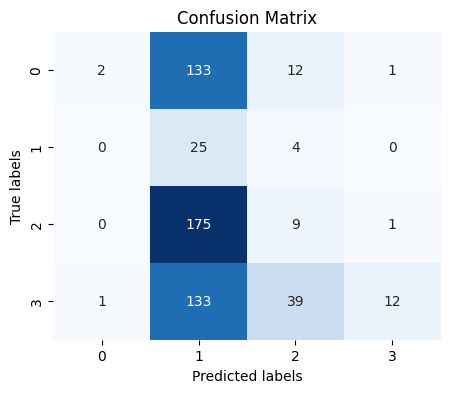

In [13]:
cm, _, accuracy, _ = evaluate_model(model, val_loader, device)
print("Metrics for current model:")
print(f'Test Accuracy: {accuracy:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))

# Обучение и валидация модели

In [11]:
# Определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

best_val_accuracy = 0

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 # loss в рамках 1 прохода по датасету (одной эпохи)
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # зануляем градиенты перед обработкой очередного батча
        outputs = model(images) # получаем предсказания модели

        loss = criterion(outputs, labels) # получаем выход функции потерь
        loss.backward() # прогоняем градиенты обратно по графу вычиялений от хвоста сети к голове
        optimizer.step() # делаем шаг градиентного спуска (обновляем веса)
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader) # средняя ошибка за один проход по данным (за 1 эпоху)
    train_accuracy = correct / total
    # сохраняем данные по эпохе
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Валидация модели
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
   
    # Сохранение лучшей модели на основе валидационной точности
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model!')
    
    # Сохранение последней актуальной модели
    torch.save(model.state_dict(), 'last_model.pth')
    print()

print('Training and validation complete!')

  1%|▏         | 1/70 [00:40<46:57, 40.84s/it]

Epoch [1/70], Train Loss: 0.4572, Train Accuracy: 0.8493, Val Loss: 2.0795, Val Accuracy: 0.6801
Saved best model!



  3%|▎         | 2/70 [01:23<47:18, 41.75s/it]

Epoch [2/70], Train Loss: 0.1669, Train Accuracy: 0.9427, Val Loss: 0.3312, Val Accuracy: 0.9214
Saved best model!



  4%|▍         | 3/70 [02:02<45:21, 40.62s/it]

Epoch [3/70], Train Loss: 0.1347, Train Accuracy: 0.9553, Val Loss: 0.3012, Val Accuracy: 0.9196



  6%|▌         | 4/70 [02:42<44:27, 40.41s/it]

Epoch [4/70], Train Loss: 0.0959, Train Accuracy: 0.9717, Val Loss: 0.2964, Val Accuracy: 0.9141



  7%|▋         | 5/70 [03:21<43:05, 39.78s/it]

Epoch [5/70], Train Loss: 0.0791, Train Accuracy: 0.9725, Val Loss: 0.1673, Val Accuracy: 0.9433
Saved best model!



  9%|▊         | 6/70 [04:03<43:15, 40.55s/it]

Epoch [6/70], Train Loss: 0.0838, Train Accuracy: 0.9749, Val Loss: 0.2721, Val Accuracy: 0.8995



 10%|█         | 7/70 [04:43<42:24, 40.38s/it]

Epoch [7/70], Train Loss: 0.0677, Train Accuracy: 0.9796, Val Loss: 0.3989, Val Accuracy: 0.8958



 11%|█▏        | 8/70 [05:25<42:16, 40.91s/it]

Epoch [8/70], Train Loss: 0.0545, Train Accuracy: 0.9804, Val Loss: 0.3052, Val Accuracy: 0.9287



 13%|█▎        | 9/70 [06:08<42:19, 41.62s/it]

Epoch [9/70], Train Loss: 0.0512, Train Accuracy: 0.9867, Val Loss: 0.2484, Val Accuracy: 0.9342



 14%|█▍        | 10/70 [06:49<41:21, 41.35s/it]

Epoch [10/70], Train Loss: 0.0231, Train Accuracy: 0.9953, Val Loss: 0.2654, Val Accuracy: 0.9342



 16%|█▌        | 11/70 [07:28<40:02, 40.72s/it]

Epoch [11/70], Train Loss: 0.0150, Train Accuracy: 0.9953, Val Loss: 0.2694, Val Accuracy: 0.9452
Saved best model!



 17%|█▋        | 12/70 [08:09<39:26, 40.80s/it]

Epoch [12/70], Train Loss: 0.0193, Train Accuracy: 0.9929, Val Loss: 0.2518, Val Accuracy: 0.9305



 19%|█▊        | 13/70 [08:52<39:30, 41.59s/it]

Epoch [13/70], Train Loss: 0.0134, Train Accuracy: 0.9961, Val Loss: 0.2408, Val Accuracy: 0.9452



 20%|██        | 14/70 [09:35<39:04, 41.86s/it]

Epoch [14/70], Train Loss: 0.0280, Train Accuracy: 0.9906, Val Loss: 0.6022, Val Accuracy: 0.8647



 21%|██▏       | 15/70 [10:17<38:19, 41.81s/it]

Epoch [15/70], Train Loss: 0.0381, Train Accuracy: 0.9859, Val Loss: 0.3537, Val Accuracy: 0.9214



 23%|██▎       | 16/70 [10:54<36:31, 40.58s/it]

Epoch [16/70], Train Loss: 0.0600, Train Accuracy: 0.9796, Val Loss: 0.3966, Val Accuracy: 0.8995



 24%|██▍       | 17/70 [11:32<34:58, 39.60s/it]

Epoch [17/70], Train Loss: 0.0620, Train Accuracy: 0.9812, Val Loss: 0.3802, Val Accuracy: 0.8995



 26%|██▌       | 18/70 [12:09<33:48, 39.02s/it]

Epoch [18/70], Train Loss: 0.0282, Train Accuracy: 0.9906, Val Loss: 0.4418, Val Accuracy: 0.8739



 27%|██▋       | 19/70 [12:48<32:58, 38.80s/it]

Epoch [19/70], Train Loss: 0.0198, Train Accuracy: 0.9914, Val Loss: 0.2163, Val Accuracy: 0.9506
Saved best model!



 29%|██▊       | 20/70 [13:26<32:12, 38.66s/it]

Epoch [20/70], Train Loss: 0.0231, Train Accuracy: 0.9945, Val Loss: 0.2277, Val Accuracy: 0.9470



 30%|███       | 21/70 [14:04<31:28, 38.54s/it]

Epoch [21/70], Train Loss: 0.0213, Train Accuracy: 0.9937, Val Loss: 0.3222, Val Accuracy: 0.9305



 31%|███▏      | 22/70 [14:42<30:40, 38.34s/it]

Epoch [22/70], Train Loss: 0.0196, Train Accuracy: 0.9929, Val Loss: 0.3297, Val Accuracy: 0.9250



 33%|███▎      | 23/70 [15:19<29:42, 37.93s/it]

Epoch [23/70], Train Loss: 0.0153, Train Accuracy: 0.9929, Val Loss: 0.2605, Val Accuracy: 0.9342



 34%|███▍      | 24/70 [15:57<29:09, 38.04s/it]

Epoch [24/70], Train Loss: 0.0128, Train Accuracy: 0.9945, Val Loss: 0.3974, Val Accuracy: 0.9214



 36%|███▌      | 25/70 [16:35<28:30, 38.00s/it]

Epoch [25/70], Train Loss: 0.0104, Train Accuracy: 0.9961, Val Loss: 0.2872, Val Accuracy: 0.9342



 37%|███▋      | 26/70 [17:15<28:14, 38.50s/it]

Epoch [26/70], Train Loss: 0.0078, Train Accuracy: 0.9976, Val Loss: 0.3061, Val Accuracy: 0.9342



 39%|███▊      | 27/70 [17:52<27:11, 37.95s/it]

Epoch [27/70], Train Loss: 0.0146, Train Accuracy: 0.9945, Val Loss: 0.3942, Val Accuracy: 0.9196



 40%|████      | 28/70 [18:29<26:21, 37.65s/it]

Epoch [28/70], Train Loss: 0.0129, Train Accuracy: 0.9961, Val Loss: 0.3788, Val Accuracy: 0.9214



 41%|████▏     | 29/70 [19:06<25:46, 37.71s/it]

Epoch [29/70], Train Loss: 0.0090, Train Accuracy: 0.9969, Val Loss: 0.3968, Val Accuracy: 0.9177



 43%|████▎     | 30/70 [19:43<24:53, 37.34s/it]

Epoch [30/70], Train Loss: 0.0141, Train Accuracy: 0.9953, Val Loss: 0.3046, Val Accuracy: 0.9415



 44%|████▍     | 31/70 [20:17<23:43, 36.51s/it]

Epoch [31/70], Train Loss: 0.0101, Train Accuracy: 0.9969, Val Loss: 0.3635, Val Accuracy: 0.9342



 46%|████▌     | 32/70 [20:51<22:34, 35.65s/it]

Epoch [32/70], Train Loss: 0.0186, Train Accuracy: 0.9953, Val Loss: 0.5192, Val Accuracy: 0.9049



 47%|████▋     | 33/70 [21:27<21:56, 35.58s/it]

Epoch [33/70], Train Loss: 0.0355, Train Accuracy: 0.9859, Val Loss: 0.3321, Val Accuracy: 0.9342



 49%|████▊     | 34/70 [22:03<21:26, 35.72s/it]

Epoch [34/70], Train Loss: 0.0488, Train Accuracy: 0.9867, Val Loss: 0.4835, Val Accuracy: 0.8995



 50%|█████     | 35/70 [22:39<20:56, 35.89s/it]

Epoch [35/70], Train Loss: 0.0823, Train Accuracy: 0.9765, Val Loss: 0.7373, Val Accuracy: 0.8501



 51%|█████▏    | 36/70 [23:15<20:25, 36.05s/it]

Epoch [36/70], Train Loss: 0.0666, Train Accuracy: 0.9819, Val Loss: 0.3820, Val Accuracy: 0.8812



 53%|█████▎    | 37/70 [23:52<19:56, 36.25s/it]

Epoch [37/70], Train Loss: 0.0336, Train Accuracy: 0.9882, Val Loss: 0.4430, Val Accuracy: 0.9141



 54%|█████▍    | 38/70 [24:28<19:16, 36.13s/it]

Epoch [38/70], Train Loss: 0.0288, Train Accuracy: 0.9906, Val Loss: 0.4105, Val Accuracy: 0.9159



 56%|█████▌    | 39/70 [25:04<18:36, 36.02s/it]

Epoch [39/70], Train Loss: 0.0370, Train Accuracy: 0.9898, Val Loss: 0.3159, Val Accuracy: 0.9250



 57%|█████▋    | 40/70 [25:39<17:55, 35.86s/it]

Epoch [40/70], Train Loss: 0.0123, Train Accuracy: 0.9961, Val Loss: 0.2415, Val Accuracy: 0.9342



 59%|█████▊    | 41/70 [26:15<17:19, 35.85s/it]

Epoch [41/70], Train Loss: 0.0084, Train Accuracy: 0.9976, Val Loss: 0.2563, Val Accuracy: 0.9324



 60%|██████    | 42/70 [26:51<16:47, 35.99s/it]

Epoch [42/70], Train Loss: 0.0036, Train Accuracy: 0.9984, Val Loss: 0.2021, Val Accuracy: 0.9397



 61%|██████▏   | 43/70 [27:28<16:18, 36.22s/it]

Epoch [43/70], Train Loss: 0.0039, Train Accuracy: 0.9992, Val Loss: 0.2286, Val Accuracy: 0.9378



 63%|██████▎   | 44/70 [28:04<15:41, 36.22s/it]

Epoch [44/70], Train Loss: 0.0022, Train Accuracy: 0.9992, Val Loss: 0.2626, Val Accuracy: 0.9360



 64%|██████▍   | 45/70 [28:41<15:06, 36.25s/it]

Epoch [45/70], Train Loss: 0.0035, Train Accuracy: 0.9976, Val Loss: 0.2778, Val Accuracy: 0.9269



 66%|██████▌   | 46/70 [29:17<14:30, 36.28s/it]

Epoch [46/70], Train Loss: 0.0157, Train Accuracy: 0.9961, Val Loss: 0.3525, Val Accuracy: 0.9214



 67%|██████▋   | 47/70 [29:53<13:51, 36.16s/it]

Epoch [47/70], Train Loss: 0.0104, Train Accuracy: 0.9961, Val Loss: 0.3761, Val Accuracy: 0.9250



 69%|██████▊   | 48/70 [30:29<13:13, 36.06s/it]

Epoch [48/70], Train Loss: 0.0118, Train Accuracy: 0.9945, Val Loss: 0.4177, Val Accuracy: 0.9141



 70%|███████   | 49/70 [31:04<12:34, 35.94s/it]

Epoch [49/70], Train Loss: 0.0104, Train Accuracy: 0.9961, Val Loss: 0.3795, Val Accuracy: 0.9177



 71%|███████▏  | 50/70 [31:40<11:56, 35.83s/it]

Epoch [50/70], Train Loss: 0.0105, Train Accuracy: 0.9961, Val Loss: 0.2872, Val Accuracy: 0.9378



 73%|███████▎  | 51/70 [32:16<11:22, 35.93s/it]

Epoch [51/70], Train Loss: 0.0047, Train Accuracy: 0.9976, Val Loss: 0.3712, Val Accuracy: 0.9287



 74%|███████▍  | 52/70 [32:53<10:54, 36.34s/it]

Epoch [52/70], Train Loss: 0.0129, Train Accuracy: 0.9953, Val Loss: 0.3427, Val Accuracy: 0.9214



 76%|███████▌  | 53/70 [33:29<10:15, 36.23s/it]

Epoch [53/70], Train Loss: 0.0127, Train Accuracy: 0.9961, Val Loss: 0.4342, Val Accuracy: 0.9122



 77%|███████▋  | 54/70 [34:06<09:41, 36.32s/it]

Epoch [54/70], Train Loss: 0.0051, Train Accuracy: 0.9984, Val Loss: 0.3166, Val Accuracy: 0.9360



 79%|███████▊  | 55/70 [34:44<09:12, 36.87s/it]

Epoch [55/70], Train Loss: 0.0120, Train Accuracy: 0.9937, Val Loss: 0.3527, Val Accuracy: 0.9086



 80%|████████  | 56/70 [35:20<08:33, 36.71s/it]

Epoch [56/70], Train Loss: 0.0102, Train Accuracy: 0.9969, Val Loss: 0.3507, Val Accuracy: 0.9232



 81%|████████▏ | 57/70 [35:56<07:55, 36.54s/it]

Epoch [57/70], Train Loss: 0.0069, Train Accuracy: 0.9976, Val Loss: 0.3839, Val Accuracy: 0.9250



 83%|████████▎ | 58/70 [36:33<07:18, 36.58s/it]

Epoch [58/70], Train Loss: 0.0223, Train Accuracy: 0.9898, Val Loss: 0.6544, Val Accuracy: 0.8903



 84%|████████▍ | 59/70 [37:10<06:43, 36.66s/it]

Epoch [59/70], Train Loss: 0.0570, Train Accuracy: 0.9812, Val Loss: 0.3985, Val Accuracy: 0.9177



 86%|████████▌ | 60/70 [37:48<06:10, 37.06s/it]

Epoch [60/70], Train Loss: 0.0328, Train Accuracy: 0.9906, Val Loss: 0.3624, Val Accuracy: 0.9177



 87%|████████▋ | 61/70 [38:26<05:36, 37.37s/it]

Epoch [61/70], Train Loss: 0.0453, Train Accuracy: 0.9882, Val Loss: 0.5467, Val Accuracy: 0.8665



 89%|████████▊ | 62/70 [39:04<05:00, 37.57s/it]

Epoch [62/70], Train Loss: 0.0366, Train Accuracy: 0.9859, Val Loss: 0.3293, Val Accuracy: 0.9269



 90%|█████████ | 63/70 [39:41<04:21, 37.38s/it]

Epoch [63/70], Train Loss: 0.0262, Train Accuracy: 0.9937, Val Loss: 0.3577, Val Accuracy: 0.9159



 91%|█████████▏| 64/70 [40:17<03:41, 37.00s/it]

Epoch [64/70], Train Loss: 0.0218, Train Accuracy: 0.9922, Val Loss: 0.2677, Val Accuracy: 0.9250



 93%|█████████▎| 65/70 [40:54<03:04, 36.86s/it]

Epoch [65/70], Train Loss: 0.0191, Train Accuracy: 0.9922, Val Loss: 0.2789, Val Accuracy: 0.9269



 94%|█████████▍| 66/70 [41:30<02:26, 36.65s/it]

Epoch [66/70], Train Loss: 0.0104, Train Accuracy: 0.9969, Val Loss: 0.3113, Val Accuracy: 0.9196



 96%|█████████▌| 67/70 [42:06<01:49, 36.55s/it]

Epoch [67/70], Train Loss: 0.0113, Train Accuracy: 0.9969, Val Loss: 0.3843, Val Accuracy: 0.9378



 97%|█████████▋| 68/70 [42:43<01:13, 36.56s/it]

Epoch [68/70], Train Loss: 0.0140, Train Accuracy: 0.9953, Val Loss: 0.3420, Val Accuracy: 0.9232



 99%|█████████▊| 69/70 [43:19<00:36, 36.46s/it]

Epoch [69/70], Train Loss: 0.0070, Train Accuracy: 0.9953, Val Loss: 0.3914, Val Accuracy: 0.9141



100%|██████████| 70/70 [43:54<00:00, 37.63s/it]

Epoch [70/70], Train Loss: 0.0034, Train Accuracy: 0.9984, Val Loss: 0.3067, Val Accuracy: 0.9378

Training and validation complete!


# Графики обучения и валидации

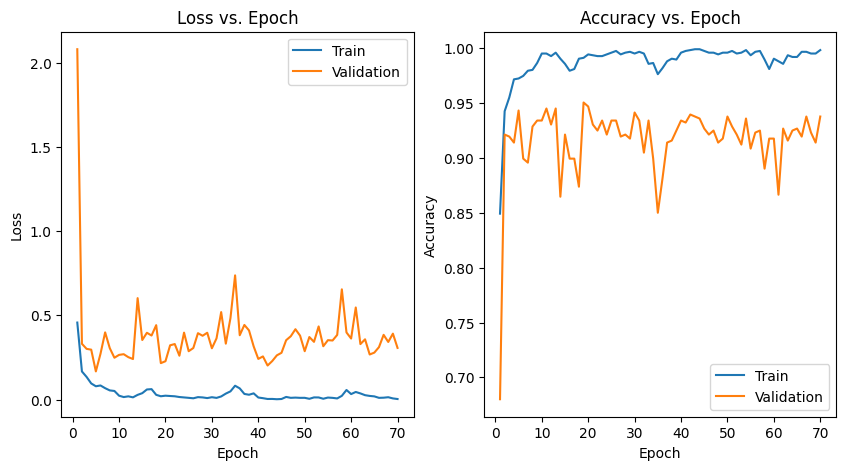

In [12]:
# Построим графики
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

# Проверка качества лучшей модели на валидационной выборке

Metrics for current model:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       148
           1       0.85      0.38      0.52        29
           2       0.96      0.98      0.97       185
           3       0.95      0.96      0.95       185

    accuracy                           0.94       547
   macro avg       0.92      0.83      0.85       547
weighted avg       0.94      0.94      0.94       547

Test Accuracy: 0.9433


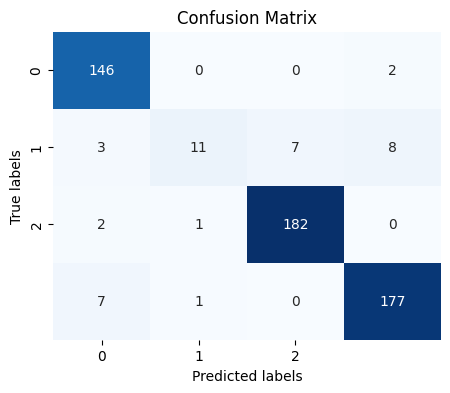

In [11]:
# Загрузка весов модели
model.load_state_dict(torch.load('./saved_models/best_model_resnet.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader, device)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

# Прогон модели на тестовых данных

In [21]:
test_csv_file = './data/test.csv'
test_images_dir = './data/images'

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # специальные значение нормализации для resnet
])

test_dataset = CustomDataset(test_csv_file, 
                             test_images_dir, 
                             classes_list, 
                             test_transform, # should be commented to print image
                             is_test=True)

2025-04-04 15:55:28,080 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.2489083].


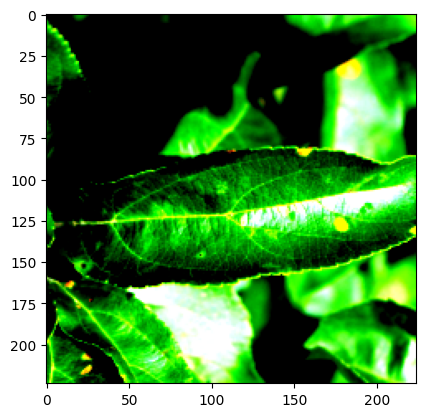

In [26]:
# Убедимся, что в датасет импортировались нужные данные
for image in test_dataset:
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    break

In [14]:
# Определяем загрузчик данных
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
propabilities = []

for images in test_loader:
    images = images.to(device)
    with torch.no_grad():
        prediction_batch = model(images)
    
    logits_batch = prediction_batch.data.cpu().detach()
    propabilities_batch = F.softmax(logits_batch, dim=1)
    propabilities.extend(propabilities_batch.tolist()) # получили список списков

In [27]:
df = pd.DataFrame(propabilities, columns=classes_list)
df = df.round(2)

In [28]:
submit_df = pd.read_csv(test_csv_file)
submit_df = pd.concat([submit_df, df], axis=1)
submit_df.to_csv('./submission.csv', index=False)

In [30]:
import torchvision.models as models